In [1]:
#!pip install powerlaw
import pandas as pd
import glob
import numpy as np
import pickle
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from collections import Counter
import powerlaw
import math
import operator

In [56]:
unique_subreddits_path =r"cleaned_data\unique_subreddits"
with open(unique_subreddits_path, 'rb') as file:
    unique_subreddits = pickle.load(file)

with open("cleaned_data\submissions_cleanead", 'rb') as file:
    submissions = pickle.load(file)

with open("cleaned_data\comments_cleanead", 'rb') as file:
    comments = pickle.load(file)

In [119]:
submissions_authors_subreddits = submissions[['author', 'subreddit']]
comments_authors_subreddits = comments[['author', 'subreddit']]

frames = [submissions_authors_subreddits,comments_authors_subreddits]
union_author_subreddit = pd.concat(frames)
union_author_subreddit.drop_duplicates(subset=None, keep="first", inplace=True)
union_author_subreddit = union_author_subreddit.sort_values(by=['author'], ascending=False)
print(union_author_subreddit)


                       author    subreddit
325999    zzzzzzzzzzzzzzzzzzz   reddit.com
363069            zzzzzzzzzzz     politics
362905            zzzzzzzzzzz   reddit.com
551567                 zzzz71   reddit.com
6168983              zzzz2008         pics
...                       ...          ...
443682   --------------------  programming
443934   --------------------   reddit.com
3052649               -------         pics
486767          *polhold00149      science
382541          *polhold00133   reddit.com

[648031 rows x 2 columns]


In [120]:
#Graph creation
SNet = nx.Graph()
SNet.add_nodes_from(set(unique_subreddits))
print(SNet.nodes)

['testingaufdeutsch', 'Military', 'ARG', 'pcmonteiro13', 'AmateurPorn', '7mooode', 'orsiko', 'dezvoltarepersonala', 'Eienelle', 'madG', 'gonewild', 'poker', 'DBpooper', 'bestentrepbooks', 'jbrains', 'forum', 'Coach4u', 'Agorism', 'CLVideos', 'WeGame', 'morrissey', 'giftfruit', 'Nurseries', 'Sporn', 'swapmeet', 'schneier', 'redditbay', 'ThisIsMyTestRun', 'comics', 'viet', 'russian', 'Suomi', 'VideoGameReviews', 'readit', 'philadelphia', 'badasshub', 'haneporg', 'ubiquity', 'Icreon', 'joel', 'CouchDB', 'Multiplayergames', 'investing', 'NSCocoa', 'sporevote', 'ada', 'StopitNow', 'weather', 'workathome', 'Gristmill', 'freelance', 'Clockwork', '777gambling', 'girlskissing', 'Polilingua', 'SignPetitions', 'secularism', 'Nima', 'motivationalspeech', 'bicycling', 'Poo', 'cycling', 'Sense', 'FlyerWiki', 'tf2', 'PawShow', 'SeeIt4Fun', 'ComProg', 'supdeeht', 'geyik', 'Neoogilvy', 'jeanculture', 'sexytern', 'cncrk', 'brasil', 'marcusjjam', 'DesignGrava', 'Zeitgeist', 'listmania', 'Bullet', 'Invite

In [249]:
def generate_nodes(node_list):
    if(len(node_list)>0): 
        list_of_edges = list(itertools.combinations(node_list,2))
        for x,y in list_of_edges:
            if (x, y) in SNet.edges:
                SNet.edges[x, y]['weight'] += 1
            else:
                SNet.add_edge(x, y, weight=1)

In [122]:
curr_author = ""
node_list = []
for _, author, subreddit in union_author_subreddit.itertuples():
    if curr_author != author:
        curr_author = author
        generate_nodes(node_list)
        node_list.clear()
    node_list.append(subreddit)

In [123]:
nx.info(SNet)
output_path = "models/SNet.gml"

nx.write_gml(SNet, output_path)

In [14]:
G = nx.read_gml("models/SNet.gml")

In [245]:
#1.7 Network density

number_of_edges = SNet.number_of_edges()
number_of_nodes = SNet.number_of_nodes()

absolut_number_of_edges = number_of_nodes * (number_of_nodes - 1)/2

network_density = number_of_edges/absolut_number_of_edges

print("Gustina mreze je = ",network_density)

Gustina mreze je =  0.016525024949303878


In [21]:
nx.info(G)

#Uklanjanje izolovanih cvorova
nx.is_connected(G)
toRemove = list(nx.isolates(G))
G.remove_nodes_from(toRemove)
nx.is_connected(G)

#Izvlacenje najvece komponente
components_array = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print('Niz povezanih komponenti: ',components_array)
print('Br povezanih komponenti: ',len(components_array))
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
largest_component = S[0]
print('Velicina najvece komponente: ',largest_component.number_of_nodes())


Niz povezanih komponenti:  [3524, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Br povezanih komponenti:  20
Velicina najvece komponente:  3524


In [ ]:
G = largest_component

In [244]:
#Save largest component

output_path = "models/SNet.gml"
nx.write_gml(G, "models/SNetLargestComponent.gml")

In [157]:
#1.8 Diameter and Avg Shortest path
diameter = nx.diameter(largest_component)
print(diameter)
#nx.average_shortest_path_length(largest_component, weight='weight') #2.45908369936751
# uradi sa i bez tezina

5


In [ ]:
#1.9 ???
#velicine komponenata
#postoji gigantska komponenta

In [172]:
#1.10 ER Model
n = G.number_of_nodes()
m = G.number_of_edges()
print("\nNumber of nodes : ", n)
print("Number of edges : ", m)

p = ( 2*float(m) ) / ( n* (n-1) )
er_net = nx.erdos_renyi_graph(n,p)

delta_m = m - er_net.number_of_edges()
print(f"Broj čvorova originalne mreže minus broj čvorova u ER mreži iznosi {delta_m}, što je odstupanje od {abs(float(delta_m)) * 100 / m}%")



Number of nodes :  3524
Number of edges :  156934
Broj čvorova originalne mreže minus broj čvorova u ER mreži iznosi 57, što je odstupanje od 0.036321001185211615%


In [187]:
#1.10 Average and global clustering coefficient, Local clustering coefficient distribution for SNet
      
average_clustering_coefficient = nx.average_clustering(G)
global_clustering_coefficient = nx.transitivity(G)

subreddit, clustering_coef = zip(*nx.clustering(G, weight = "weight").items())
local_clustering_data = [(subreddit, cc)  for subreddit, cc in zip(subreddit, clustering_coef) if cc > 0]
local_clustering_coefficients = pd.DataFrame(local_clustering_data, columns = ["subreddit", "cc"])
local_clustering_coefficients.sort_values('cc', inplace = True, ascending=False)

print("Average clustering coefficient : ", average_clustering_coefficient)
print("Global clustering coefficient : ", global_clustering_coefficient)
print("Local clustering coefficients\n", local_clustering_coefficients)

plt.hist(local_clustering_coefficients['cc'], color = 'pink', edgecolor = 'black',
         bins = int(300/5))

plt.title('Local clustering coefficient distribution')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Number of nodes')
plt.tight_layout()
plt.show()


Average clustering coefficient :  0.7705443947900459
Global clustering coefficient :  0.26730816965364673
Local clustering coefficients
            subreddit        cc
2359    Plugyoursite  0.001133
804       ryanbulmer  0.001091
2160      Indyapulse  0.001077
470             Fish  0.001054
105     redditCANADA  0.001038
...              ...       ...
2746           Liang  0.000033
849   Ambientalmente  0.000032
2479            Voto  0.000016
2807    kultur_sanat  0.000011
1127         Turkiye  0.000011

[2991 rows x 2 columns]


Average clustering coefficient :  0.025273234845362435
Global clustering coefficient :  0.025267744160115842
Local clustering coefficients
       subreddit        cc
1629       1629  0.037681
612         612  0.034369
1204       1204  0.033674
2484       2484  0.032864
359         359  0.032809
...         ...       ...
1032       1032  0.017593
2426       2426  0.017514
658         658  0.016963
1604       1604  0.016729
548         548  0.015066

[3524 rows x 2 columns]


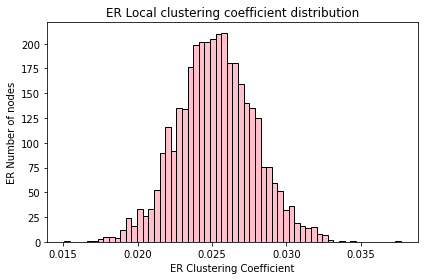

In [190]:
#1.10 Average and global clustering coefficient, Local clustering coefficient distribution for ER Net

average_clustering_coefficient_er = nx.average_clustering(er_net)
global_clustering_coefficient_er = nx.transitivity(er_net)


subreddit_er, clustering_coef_er = zip(*nx.clustering(er_net, weight = "weight").items())
local_clustering_data_er = [(subreddit, cc)  for subreddit, cc in zip(subreddit_er, clustering_coef_er) if cc > 0]
local_clustering_coefficients_er = pd.DataFrame(local_clustering_data_er, columns = ["subreddit", "cc"])
local_clustering_coefficients_er.sort_values('cc', inplace = True, ascending=False)

print("Average clustering coefficient : ", average_clustering_coefficient_er)
print("Global clustering coefficient : ", global_clustering_coefficient_er)
print("Local clustering coefficients\n", local_clustering_coefficients_er)

plt.hist(local_clustering_coefficients_er['cc'], color = 'pink', edgecolor = 'black',
         bins = int(300/5))

plt.title('ER Local clustering coefficient distribution')
plt.xlabel('ER Clustering Coefficient')
plt.ylabel('ER Number of nodes')
plt.tight_layout()
plt.show()

In [ ]:
#1.11 avg shortest path i clustering coef poredjen sa random mrezom

In [192]:
#1.12
# asortativnost na osnovu netežinskog stepena čvora
r1 = nx.degree_assortativity_coefficient(G)
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: {r1}")

# asortativnost na osnovu težinskog stepena čvora
#r2 = nx.degree_assortativity_coefficient(G, weight='weight') - ne moze da se izracuna na lokalnoj masini
#print(f"Koeficijent asortativnosti na osnovu težinskog stepena čvora: {r2}")

Koeficijent asortativnosti na osnovu netežinskog stepena čvora: -0.4367025375401105


In [ ]:
#1.12 HAVEL HAKIMI analiza !!!

In [ ]:
#1.13 Ne ispoljava rich club phenomenon

In [ ]:
#1.14

In [203]:
def plot_deg_frequency(G, weighted = False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
        
    _, deg_list = zip(*degrees)
    deg_counts = Counter(deg_list)        
    print(deg_counts)
    x, y = zip(*deg_counts.items())                                                      

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(y))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()

Counter({1: 530, 2: 250, 3: 148, 5: 97, 4: 86, 6: 77, 11: 50, 10: 44, 7: 43, 8: 43, 18: 41, 16: 39, 14: 39, 13: 38, 12: 38, 9: 36, 24: 35, 29: 31, 20: 31, 25: 30, 17: 30, 21: 29, 19: 29, 23: 28, 22: 28, 26: 27, 28: 27, 15: 25, 43: 25, 31: 23, 30: 23, 38: 22, 33: 22, 78: 21, 49: 20, 32: 20, 36: 19, 39: 19, 45: 19, 44: 18, 48: 17, 27: 17, 50: 17, 37: 17, 56: 16, 41: 16, 64: 16, 42: 16, 35: 15, 121: 15, 40: 15, 34: 14, 55: 14, 180: 14, 83: 14, 57: 14, 74: 13, 75: 13, 46: 13, 84: 13, 68: 12, 52: 12, 54: 12, 62: 11, 51: 11, 61: 11, 67: 11, 95: 11, 60: 11, 58: 10, 90: 10, 59: 10, 96: 10, 71: 10, 66: 9, 72: 9, 99: 9, 101: 9, 47: 9, 81: 8, 69: 8, 103: 8, 80: 8, 89: 8, 73: 8, 122: 8, 115: 8, 92: 8, 86: 8, 93: 8, 63: 7, 114: 7, 65: 7, 76: 7, 135: 7, 102: 7, 91: 7, 157: 7, 125: 7, 106: 7, 85: 7, 70: 7, 192: 7, 140: 6, 138: 6, 120: 6, 228: 6, 109: 6, 53: 5, 88: 5, 105: 5, 193: 5, 100: 5, 153: 5, 162: 5, 256: 5, 127: 5, 132: 5, 87: 5, 98: 5, 149: 5, 181: 5, 107: 5, 104: 5, 183: 5, 134: 4, 200: 4, 7

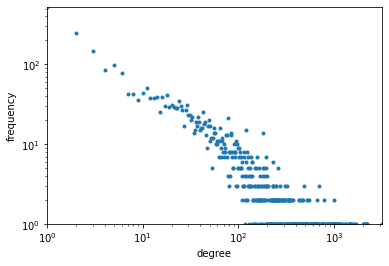

In [204]:
plot_deg_frequency(G)

Counter({1: 525, 2: 243, 3: 146, 5: 94, 4: 81, 6: 77, 7: 47, 11: 47, 18: 42, 10: 41, 14: 39, 13: 38, 8: 38, 21: 37, 24: 35, 12: 34, 19: 33, 16: 31, 9: 30, 25: 30, 17: 27, 29: 26, 28: 26, 22: 25, 43: 25, 26: 24, 20: 24, 15: 23, 38: 23, 23: 23, 64: 23, 27: 22, 40: 21, 31: 20, 78: 19, 45: 18, 34: 18, 36: 16, 44: 16, 57: 16, 30: 16, 39: 15, 33: 14, 48: 14, 35: 14, 67: 14, 121: 14, 32: 14, 49: 13, 52: 13, 56: 12, 51: 12, 76: 12, 41: 12, 61: 12, 59: 12, 54: 11, 50: 11, 37: 11, 46: 11, 74: 10, 90: 10, 42: 10, 85: 10, 83: 10, 94: 9, 180: 9, 53: 8, 79: 8, 68: 8, 106: 8, 120: 8, 55: 8, 75: 7, 117: 7, 112: 7, 181: 7, 71: 7, 110: 7, 98: 6, 114: 6, 73: 6, 47: 6, 58: 6, 89: 6, 185: 6, 107: 6, 65: 6, 62: 6, 128: 5, 91: 5, 77: 5, 235: 5, 80: 5, 72: 5, 152: 5, 133: 5, 176: 5, 102: 5, 104: 5, 127: 5, 153: 5, 60: 5, 199: 5, 167: 5, 69: 5, 86: 5, 214: 5, 101: 5, 81: 5, 124: 5, 221: 4, 99: 4, 84: 4, 105: 4, 219: 4, 82: 4, 175: 4, 159: 4, 163: 4, 149: 4, 177: 4, 238: 4, 66: 4, 118: 4, 92: 4, 242: 4, 203: 4,

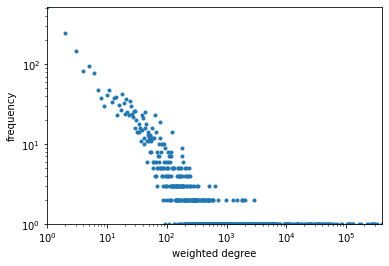

In [205]:
plot_deg_frequency(G, weighted = True)

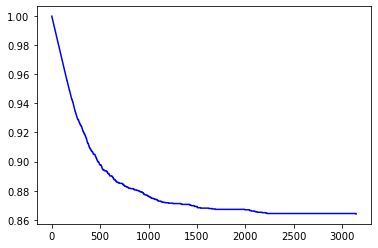

In [206]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

max_deg = max(deg) # hoćemo po jedan bin za svaki stepen čvora

# izračunavanje histograma
values, base = np.histogram(deg, bins = max_deg)

# kumulativna suma (inkluzivna prefiksna suma)
cumulative = np.cumsum(values)

# plotovanje komplementarne kumulativne raspodele stepena čvora P(X>x)
plt.plot(base[:-1], [float(x)/len(G) for x in len(G) - cumulative], c='blue')

plt.show()

In [200]:
results = powerlaw.Fit(degree_sequence)

print(results.supported_distributions)


Calculating best minimal value for power law fit
{'power_law': <class 'powerlaw.Power_Law'>, 'lognormal': <class 'powerlaw.Lognormal'>, 'exponential': <class 'powerlaw.Exponential'>, 'truncated_power_law': <class 'powerlaw.Truncated_Power_Law'>, 'stretched_exponential': <class 'powerlaw.Stretched_Exponential'>, 'lognormal_positive': <class 'powerlaw.Lognormal_Positive'>}


In [202]:
print(results.power_law.alpha)
print(results.power_law.xmin)
print(results.power_law.sigma)
R, p = results.distribution_compare('power_law', 'lognormal')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('power_law', 'exponential')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('power_law', 'truncated_power_law')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")

2.2464911508648253
156.0
0.056025610831647574
Loglikelihood ratio: -12.644147229109814
Statistical significance: 0.001085624099228952
Loglikelihood ratio: 22.582676543743453
Statistical significance: 0.0730904396689174
Loglikelihood ratio: -15.613893371177623
Statistical significance: 2.2945806810170666e-08


Assuming nested distributions


In [ ]:
# Na log log grafiku kumulativne raspodele nismo dobili pravu pa je prvi zakljucak da ovaj graf ne fituje u power law raspodelu.
# Dalje se to potvrdjuje na osnovu poredjenja distribucije, najvise deluje da je truncated power law raspodela

In [250]:
#1.15 Habovi i autoriteti
hubs, authorities =nx.hits(G)

hub_items = sorted(hubs.items(), key=operator.itemgetter(1), reverse=True)[:10]
print("SNetF Hubs\n")
for hub_item in hub_items:
    print(hub_item)

authority_items = sorted(authorities.items(), key=operator.itemgetter(1), reverse=True)[:10]
print("\nSNetF Authorities\n")
for authority_item in authority_items:
    print(authority_item)

SNetF Hubs

('reddit.com', 0.06348926760970038)
('politics', 0.052982234075963114)
('pics', 0.04945525123782549)
('funny', 0.04737307262558192)
('science', 0.0462683107146239)
('technology', 0.044726776059512495)
('worldnews', 0.04386665890786076)
('WTF', 0.04362186915945341)
('entertainment', 0.04186640209208637)
('programming', 0.037392328450116974)

SNetF Authorities

('reddit.com', 0.06348926761103306)
('politics', 0.05298223407535796)
('pics', 0.04945525123766796)
('funny', 0.04737307262546547)
('science', 0.046268310714548344)
('technology', 0.04472677605931482)
('worldnews', 0.04386665890780224)
('WTF', 0.04362186915941283)
('entertainment', 0.041866402091888986)
('programming', 0.037392328450020065)


In [263]:
#Find core nodes

core_number = nx.core_number(G)
max_core_number = max(core_number.values())
print("Max core number : ", max_core_number)

core = nx.k_core(G, max_core_number)
for node in core:
    print(node)
    
#Poredjenjem je utvrdjeno da su svi habovi/autoriteti u jezgru mreze

Max core number :  192
fejl  Military
fejl  Green
fejl  browsers
fejl  fashion
fejl  Poetry
fejl  Frugal
fejl  gonewild
fejl  productivity
fejl  video
fejl  opensource
fejl  socialmedia
fejl  WebGames
fejl  iphone
fejl  gardening
fejl  tech
fejl  euro
fejl  ZenHabits
fejl  MensRights
fejl  self
fejl  pic
fejl  WorldWideNews
fejl  investing
fejl  Graffiti
fejl  Jokes
fejl  perl
fejl  askXKCD
fejl  aww
fejl  web_design
fejl  government
fejl  Christianity
fejl  astro
fejl  Transhuman
fejl  bicycling
fejl  osx
fejl  lgbt
fejl  Metal
fejl  conspiracy
fejl  l33t
fejl  Buddhism
fejl  craigslist
fejl  Art
fejl  wikipedia
fejl  ComputerSecurity
fejl  area51
fejl  religion
fejl  Paranormal
fejl  space
fejl  sports
fejl  webcomics
fejl  veg
fejl  literature
fejl  idea
fejl  Cooking
fejl  Anarchism
fejl  recipes
fejl  books
fejl  war
fejl  auto
fejl  geopolitics
fejl  psychology
fejl  BlackOps
fejl  nature
fejl  ArtCrit
fejl  apple
fejl  worstof
fejl  newreddits
fejl  anime
fejl  dailywtf
fejl  Am

In [227]:
#1.16 
#degree_centrality, closeness_centrality, betweenes_centrality
print("Top 10 Degree centrality:\n")
DC = nx.degree_centrality(G)
dc_items = sorted(DC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for dc_item in dc_items:
    print(dc_item[0], "\t\t",dc_item[1], "\t",G.degree[dc_item[0]])


Top 10 Degree centrality:
reddit.com 		 0.8921373829122906 	 3143
technology 		 0.6304286119784275 	 2221
politics 		 0.6275901220550667 	 2211
pics 		 0.6162361623616236 	 2171
funny 		 0.6026114107294919 	 2123
science 		 0.5975021288674425 	 2105
worldnews 		 0.5935282429747374 	 2091
entertainment 		 0.5850127732046551 	 2061
WTF 		 0.5801873403349418 	 2044
programming 		 0.5799034913426058 	 2043


In [228]:
print("Top 10 Closeness centrality:\n\n")
CC = nx.closeness_centrality(G)
cc_items = sorted(CC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for cc_item in cc_items:
    node = cc_item[0]
    print(cc_item[0], "   ", cc_item[1])

print("\nTop 10 Betweenness centrality:\n")
BC = nx.betweenness_centrality(G)
bc_items = sorted(BC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for bc_item in bc_items:
    node = bc_item[0];
    print(bc_item[0], "   ", bc_item[1])


Closeness centrality:
reddit.com     0.9019457245263697     3143
technology     0.7283440148852595     2221
politics     0.7260923330585326     2211
pics     0.7201553556827474     2171
funny     0.7125809061488673     2123
science     0.710139084861923     2105
worldnews     0.7084254976875126     2091
entertainment     0.7040367705835332     2061
WTF     0.7013736810670914     2044
programming     0.700815595782773     2043
Betweenness centrality:
reddit.com     0.3686547520487645     3143
technology     0.04937105642143906     2221
programming     0.04363491513740279     2043
politics     0.04304902436498485     2211
business     0.04129223409955247     1994


In [229]:
#1.17 Eigenvector centrality
#Napomena naci zasto su ovakvi rezultati

print("\nTop 10 Eigenvector centrality:\n")
EC = nx.eigenvector_centrality(G)
ec_items = sorted(EC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for ec_item in ec_items:
    print(ec_item[0], "   ", ec_item[1])



Top 10 Eigenvector centrality:

reddit.com     0.0869853759151425
politics     0.0849974875047629
technology     0.08495275088747631
pics     0.08488712702959006
science     0.0846269016537996
funny     0.08459504891566152
worldnews     0.08421867967487955
WTF     0.08368474037729566
entertainment     0.08336384940437629
programming     0.08281215543735897


In [3]:
#1.18 Katzova centralnost

def calculate_beta(default_beta, reddit_beta):
    dict = {}
    i = 0
    for node in G.nodes():
        if node == 'reddit.com':
            dict[node] = reddit_beta
        else:
            dict[node] = default_beta
        i+=1
        
    return dict


In [4]:
lambda_max =  max(nx.adjacency_spectrum(G))
print(1/lambda_max)

(5.451925984405687e-06+0j)


In [5]:
KC = nx.katz_centrality(G, alpha=1/(2*lambda_max), beta=1.0, max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight=None)
kc_items = sorted(KC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for kc_item in kc_items:
    print(kc_item[0], "   ", kc_item[1])

reddit.com     (0.015273098900518325+0j)
technology     (0.01523503821027116+0j)
politics     (0.015234625345939582+0j)
pics     (0.015232974126722755+0j)
funny     (0.015230992597923642+0j)
science     (0.015230249630723917+0j)
worldnews     (0.015229671563045314+0j)
entertainment     (0.015228432969938055+0j)
WTF     (0.015227731246410805+0j)
programming     (0.015227689795011438+0j)


C:\Users\sretenp\Anaconda3\lib\site-packages\networkx\algorithms\centrality\katz.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
  s = 1.0 / sqrt(sum(v ** 2 for v in x.values()))


In [6]:
KC = nx.katz_centrality(G, alpha=1/(2*lambda_max), beta=1.0, max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight='weight')
kc_items = sorted(KC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for kc_item in kc_items:
    print(kc_item[0], "   ", kc_item[1])

reddit.com     (0.04750841832002927+0j)
politics     (0.041888884286598135+0j)
pics     (0.0402947088873711+0j)
funny     (0.03923188438544093+0j)
science     (0.03875406522475151+0j)
technology     (0.03792700762289277+0j)
WTF     (0.037413989587874646+0j)
worldnews     (0.03741262673799614+0j)
entertainment     (0.036423310911065765+0j)
programming     (0.034095006170716556+0j)


In [10]:
KC = nx.katz_centrality(G, alpha=1/(2*lambda_max), beta=calculate_beta(1,2), max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight='weight')
kc_items = sorted(KC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for kc_item in kc_items:
    print(kc_item[0], "   ", kc_item[1])

reddit.com     (0.06349001857351431+0j)
politics     (0.04387267950730567+0j)
pics     (0.042011669777274815+0j)
funny     (0.04085804970500777+0j)
science     (0.04033026330552025+0j)
technology     (0.03949476190703619+0j)
worldnews     (0.03890314148482572+0j)
WTF     (0.03887091569465365+0j)
entertainment     (0.03789771889121953+0j)
programming     (0.03537494299238236+0j)


In [9]:
KC = nx.katz_centrality(G, alpha=1/(2*lambda_max), beta=calculate_beta(1,4), max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight='weight')
kc_items = sorted(KC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for kc_item in kc_items:
    print(kc_item[0], "   ", kc_item[1])

reddit.com     (0.060598214922778934+0j)
technology     (0.015208848474197666+0j)
politics     (0.015208436320273189+0j)
pics     (0.015206787940925493+0j)
funny     (0.01520480981947628+0j)
science     (0.01520406813014439+0j)
worldnews     (0.015203491056191636+0j)
entertainment     (0.015202254589924857+0j)
WTF     (0.015201554074713993+0j)
programming     (0.015201512682777819+0j)


In [ ]:
#1.20 Spektralna analiza
#Veliki graf, ne moze zbog 0(n^3)


In [246]:
#1.23
bridges = list(nx.bridges(G))
potential_brokers = []
for bridge in bridges:
    potential_brokers.append(bridge[0])
    potential_brokers.append(bridge[1])
print('Potencijalni najuticajniji brokeri: ',set(potential_brokers))

Potencijalni najuticajniji brokeri:  {'HomeBrewNews', 'QuickBooker', 'dezvoltarepersonala', 'BloZip', 'FiduciaryInvestment', 'ChoosyHomeschoolers', 'PUAmethod', 'Coach4u', 'ThisIsMyTestRun', 'reddit.com', 'captainreboot', 'elain', 'Nurseries', 'Vanhomeless', 'callingIT', 'joesholmes', 'comics', 'gaming', 'Alexanderc', 'sexyjapanx', 'NSCocoa', 'sporevote', 'workathome', 'contrarian', 'Polilingua', 'Nima', 'Sense', 'FlyerWiki', 'PawShow', 'off_topic', 'ChileRemix', 'ComProg', 'HouseMusic', 'awwcute', 'cncrk', 'xaluan', 'rentcentralpa', 'wrexham', 'listmania', 'Mosaic_Interactive', 'Mackorisnik', 'realsurf', 'MilitantStuggles', 'Hair', 'social_bookmarking', 'civilengineering', 'shtruc', 'word', 'Archana', 'Ambientalmente', 'GreenEnergyNews', 'Gabrella', 'ads', 'Dirtfloor', 'WendyM', 'relationships', 'Authenticfashion', 'nsfw2', 'Sleeptreatment', 'JaneDing', 'entertainment', 'vancec', 'exboyfriendback', 'Sherewizki', 'adekeda', 'bulgaria', 'matija', 'Pauliespoint', 'GreenTree', 'e2mars', '

In [247]:
print('Najuticajniji brokeri na osnovu relacione centralnosti')
bc_items = sorted(BC.items(), key=operator.itemgetter(1), reverse=True)[:]
for bc_item in bc_items:
    if bc_item[0] in set(potential_brokers) and bc_item[1]>0:
        print(bc_item[0], "   ", bc_item[1])

Najuticajniji brokeri na osnovu relacione centralnosti
reddit.com     0.3686547520487645
technology     0.04937105642143906
programming     0.04363491513740279
politics     0.04304902436498485
business     0.04129223409955247
entertainment     0.03775667884001717
pics     0.03760614288944095
worldnews     0.03365842774623493
funny     0.032314804042720656
science     0.031917276291879515
WTF     0.02849546111627981
Chinese     0.014044014687369351
gaming     0.012221818395893997
Economics     0.010733825991583741
AskReddit     0.010028973351065664
nsfw     0.010000297129988444
environment     0.009430288969051627
atheism     0.008630839752859073
comics     0.007200097548767125
obama     0.005407476941709801
Health     0.004994144165884502
it     0.0044598562028012765
ads     0.004392895906832522
sports     0.0041240444080981545
es     0.004034831456892147
gossip     0.0032146865841833627
cogsci     0.0029586772426389357
de     0.0027909646564102768
Marijuana     0.002734033763997474
ma